In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import pdb
import requests
import matplotlib.pyplot as plt
from collections import defaultdict
import random 
import time

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import *

from functools import wraps
from time import time as _timenow 
from sys import stderr

## Load CIFAR-10 Data

In [2]:
def load_cifar():
    
    trn_data, trn_labels, tst_data, tst_labels = [], [], [], []
    def unpickle(file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='latin1')
        return data
    
    for i in trange(1):
        batchName = './data/data_batch_{0}'.format(i + 1)
        unpickled = unpickle(batchName)
        trn_data.extend(unpickled['data'])
        trn_labels.extend(unpickled['labels'])
    unpickled = unpickle('./data/test_batch')
    tst_data.extend(unpickled['data'])
    tst_labels.extend(unpickled['labels'])
    return trn_data, trn_labels, tst_data, tst_labels


## Image preprocessing

In [3]:
def image_prep(image):
    processed_image = image
#     m = np.mean(image, axis=0)
#     sd = np.std(image, axis=0)
#     processed_image = image - m
#     processed_image = processed_image/sd
    ''' pre-processes the given image
        performs mean normalization and other such operations'''
    return processed_image

## Dimensionality reduction using PCA

In [4]:
def reduce_dim(**kwargs):
    dim = kwargs['dim']
    train_X = kwargs['train_X']
    train_y = kwargs['train_y']
    ''' performs dimensionality reduction'''
    if kwargs['method'] == 'pca':
        pca = PCA(n_components=dim)
        pca.fit(train_X)
        X_reduced = pca.transform(train_X)
        return pca, X_reduced
    
    if kwargs['method'] == 'lda':
        lda = LinearDiscriminantAnalysis(n_components=dim)
        lda.fit(train_X,train_y)
        X_reduced = lda.transform(train_X)
        return lda, X_reduced        

## Classification using kernel SVM

In [5]:
def classify(X, y, **kwargs):
    ''' trains a classifier by taking input features
        and their respective targets and returns the trained model'''
    if kwargs['method'] == 'Logistic Regression':
        clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
        clf = clf.fit(X, y)
        return clf
    if kwargs['method'] == 'Decision Tree':
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X, y)
        return clf

## Evaluation 

In [6]:
def evaluate(target, predicted):
    f1 = f1_score(target, predicted, average='micro')
    acc = accuracy_score(target, predicted)
    return f1, acc

In [7]:
def test(**kwargs):
    classifer_model = kwargs['classifer_model']
    test_X = kwargs['test_X']
    test_y = kwargs['test_y']
    predicted_y = classifer_model.predict(test_X)
    f1, acc = evaluate(test_y, predicted=predicted_y)
    print(f1)
    print(acc)
    return f1, acc

In [8]:
dec_PCA_acc = []
dec_PCA_f1 = []
def main1():
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    trn_data, tst_data = list(map(image_prep, trn_data)), list(map(image_prep, tst_data))
    X_train, X_val, y_train, y_val = train_test_split(trn_data, trn_labels,test_size = 0.20)

    dims=[1,2,4,8,16,32,64,128,256]
    for dim in dims:
        print(dim)
        reduced_model, X_reduced = reduce_dim(method='lda',dim=dim,train_X = X_train,train_y = y_train)
        classifer_model = classify(X_reduced, y_train, method='Logistic Regression')
        test_X_reduced = reduced_model.transform(X_val)
        f1, acc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
        dec_PCA_acc.append(acc)
        dec_PCA_f1.append(f1)

In [9]:
if __name__ == '__main__':
    main1()

100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


1
0.162
0.162
2
0.1995
0.1995
4
0.2285
0.2285
8
0.243
0.243
16
0.2335
0.2335
32
0.2335
0.2335
64
0.2335
0.2335
128
0.2335
0.2335
256
0.2335
0.2335


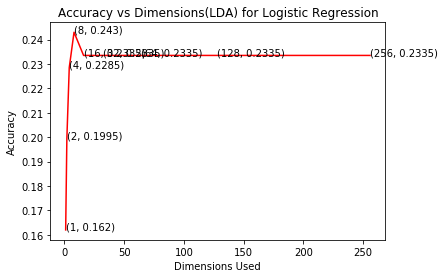

In [10]:
dims=[1,2,4,8,16,32,64,128,256]
for i in range(1,len(dec_PCA_acc)):
#     print(i)
    dec_PCA_f1[i] = round(dec_PCA_f1[i], 3)
#     print(i)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(dims,dec_PCA_acc,'r')
plt.xlabel('Dimensions Used')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dimensions(LDA) for Logistic Regression')
for xy in zip(dims, dec_PCA_acc):
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.savefig('finallogisticreg_LDA_accuracy_1.svg',format='svg')

In [11]:
print(dec_PCA_f1)
print(dims)
data = {'Dimensions' : dims,
        'Accuracy':dec_PCA_f1,
#         'Score':svm_PCA_f1
       }
p = pd.DataFrame(data)
columnsTitles=["Dimensions","Accuracy"]
p = p.reindex(columns=columnsTitles)
p.index = range(1,10)
# print(p)
# print(svm_PCA_f1)
p

[0.162, 0.2, 0.228, 0.243, 0.234, 0.234, 0.234, 0.234, 0.234]
[1, 2, 4, 8, 16, 32, 64, 128, 256]


,Dimensions,Accuracy
1,1,0.162
2,2,0.200
3,4,0.228
4,8,0.243
5,16,0.234
6,32,0.234
7,64,0.234
8,128,0.234
9,256,0.234


In [12]:
def sethyperparam(X, y, **kwargs):
     if kwargs['method'] == 'Logistic Regression':
            max_iter = kwargs['max_iter']
            penalty = kwargs['penalty']
            dual = kwargs['dual']
            solver = kwargs['solver']
            clf = LogisticRegression(solver=solver,multi_class='auto',penalty=penalty, dual=dual, max_iter=max_iter)
            clf = clf.fit(X, y)
            return clf

In [13]:
trn_data, trn_labels, tst_data, tst_labels = load_cifar()
trn_data, tst_data = list(map(image_prep, trn_data)), list(map(image_prep, tst_data))
X_train, X_val, y_train, y_val = train_test_split(trn_data, trn_labels,test_size = 0.20)
 
reduced_model, X_reduced = reduce_dim(method='lda',dim=8,train_X = X_train,train_y = y_train)
test_X_reduced = reduced_model.transform(X_val)
reducedtestdata = reduced_model.transform(tst_data)

100%|██████████| 1/1 [00:00<00:00, 20.59it/s]


In [14]:
C_range = [0.5, 1, 2.5]
max_iter_range = [200,500]
penalty_range = ['l1','l2']
svm_PCA_acc1 = []
svm_PCA_f11 = []
def main2():
    
    for penalty in penalty_range:
        if penalty == 'l2':
            for c in C_range:
                for max_iter in max_iter_range:
                    print('liblinear',penalty, c, max_iter)
                    classifer_model =  sethyperparam(X_reduced, y_train, method='Logistic Regression', solver='liblinear',penalty='l2', dual=False, max_iter=max_iter)
                    testf1, testacc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
                    trainf1, trainacc = test(classifer_model=classifer_model,test_X = X_reduced, test_y = y_train)
                    svm_PCA_acc1.append(testacc)
                    svm_PCA_f11.append(trainacc)
                    
        if penalty == 'l2':
            for c in C_range:
                for max_iter in max_iter_range:
                    print('lbfgs',penalty, c, max_iter)
                    classifer_model = sethyperparam(X_reduced, y_train, method='Logistic Regression', solver='lbfgs',penalty='l2', dual=False, max_iter=max_iter)
                    testf1, testacc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
                    trainf1, trainacc = test(classifer_model=classifer_model,test_X = X_reduced, test_y = y_train)
                    svm_PCA_acc1.append(testacc)
                    svm_PCA_f11.append(trainacc)

        if penalty == 'l1':
            for c in C_range:
                for max_iter in max_iter_range:
                    print(penalty, c, max_iter)
                    classifer_model =  sethyperparam(X_reduced, y_train, method='Logistic Regression', solver='liblinear',penalty='l1', dual=False, max_iter=max_iter)
                    testf1, testacc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
                    trainf1, trainacc = test(classifer_model=classifer_model,test_X = X_reduced, test_y = y_train)
                    svm_PCA_acc1.append(testacc)
                    svm_PCA_f11.append(trainacc)
main2()

l1 0.5 200
0.2245
0.2245
0.824625
0.824625
l1 0.5 500
0.2245
0.2245
0.824625
0.824625
l1 1 200
0.2245
0.2245
0.824625
0.824625
l1 1 500
0.2245
0.2245
0.824625
0.824625
l1 2.5 200
0.2245
0.2245
0.824625
0.824625
l1 2.5 500
0.2245
0.2245
0.824625
0.824625
liblinear l2 0.5 200
0.2245
0.2245
0.825125
0.825125
liblinear l2 0.5 500
0.2245
0.2245
0.825125
0.825125
liblinear l2 1 200
0.2245
0.2245
0.825125
0.825125
liblinear l2 1 500
0.2245
0.2245
0.825125
0.825125
liblinear l2 2.5 200
0.2245
0.2245
0.825125
0.825125
liblinear l2 2.5 500
0.2245
0.2245
0.825125
0.825125
lbfgs l2 0.5 200
0.229
0.229
0.827
0.827
lbfgs l2 0.5 500
0.229
0.229
0.827
0.827
lbfgs l2 1 200
0.229
0.229
0.827
0.827
lbfgs l2 1 500
0.229
0.229
0.827
0.827
lbfgs l2 2.5 200
0.229
0.229
0.827
0.827
lbfgs l2 2.5 500
0.229
0.229
0.827
0.827


In [15]:
temp_C = []
temp_maxitr = []
temp_penality = []
temp_solver = []
for i in range(len(C_range)):
    for j in range (len(max_iter_range)):
        temp_C.append(C_range[i])
        temp_maxitr.append(max_iter_range[j])
        temp_penality.append('l1')
        temp_solver.append('liblinear')

for i in range(len(C_range)):
    for j in range (len(max_iter_range)):
        temp_C.append(C_range[i])
        temp_maxitr.append(max_iter_range[j])
        temp_penality.append('l2')
        temp_solver.append('liblinear')
        
for i in range(len(C_range)):
    for j in range (len(max_iter_range)):
        temp_C.append(C_range[i])
        temp_maxitr.append(max_iter_range[j])
        temp_penality.append('l2')
        temp_solver.append('lbfgs')

In [16]:
print(temp_C)
print(temp_maxitr)
print(temp_penality)
print(temp_solver)
print(svm_PCA_acc1)
print(svm_PCA_f11)

[0.5, 0.5, 1, 1, 2.5, 2.5, 0.5, 0.5, 1, 1, 2.5, 2.5, 0.5, 0.5, 1, 1, 2.5, 2.5]
[200, 500, 200, 500, 200, 500, 200, 500, 200, 500, 200, 500, 200, 500, 200, 500, 200, 500]
['l1', 'l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2']
['liblinear', 'liblinear', 'liblinear', 'liblinear', 'liblinear', 'liblinear', 'liblinear', 'liblinear', 'liblinear', 'liblinear', 'liblinear', 'liblinear', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs']
[0.2245, 0.2245, 0.2245, 0.2245, 0.2245, 0.2245, 0.2245, 0.2245, 0.2245, 0.2245, 0.2245, 0.2245, 0.229, 0.229, 0.229, 0.229, 0.229, 0.229]
[0.824625, 0.824625, 0.824625, 0.824625, 0.824625, 0.824625, 0.825125, 0.825125, 0.825125, 0.825125, 0.825125, 0.825125, 0.827, 0.827, 0.827, 0.827, 0.827, 0.827]


In [17]:
data1 = {'Solver' : temp_solver,
         'Penality' : temp_penality,
         'Max iterations' : temp_maxitr,
         'C' : temp_C,
         'Test Accuracy' : svm_PCA_acc1,
         'Train Accuracy' : svm_PCA_f11
#         'Score':svm_PCA_f1
       }
p1 = pd.DataFrame(data1)
columnsTitles=["Solver","Penality", "Max iterations","C", "Test Accuracy", "Train Accuracy"]
p1 = p1.reindex(columns=columnsTitles)
p1.index = range(1,19)
p1

,Solver,Penality,Max iterations,C,Test Accuracy,Train Accuracy
1,liblinear,l1,200,0.5,0.2245,0.824625
2,liblinear,l1,500,0.5,0.2245,0.824625
3,liblinear,l1,200,1.0,0.2245,0.824625
4,liblinear,l1,500,1.0,0.2245,0.824625
5,liblinear,l1,200,2.5,0.2245,0.824625
6,liblinear,l1,500,2.5,0.2245,0.824625
7,liblinear,l2,200,0.5,0.2245,0.825125
8,liblinear,l2,500,0.5,0.2245,0.825125
9,liblinear,l2,200,1.0,0.2245,0.825125
10,liblinear,l2,500,1.0,0.2245,0.825125


In [18]:
classifer_model = classifer_model = sethyperparam(X_reduced, y_train, method='Logistic Regression', solver='liblinear',penalty='l1', dual=False, max_iter=200, C=1)
testf1, testacc = test(classifer_model=classifer_model,test_X = test_X_reduced, test_y = y_val)
test(classifer_model=classifer_model,test_X = reducedtestdata, test_y = tst_labels)

0.2245
0.2245
0.2294
0.2294


(0.2294, 0.2294)